# Problema: Predicción de retrasos en aviones

Los objetivos de este bloc de notas son:
Procesar y crear un conjunto de datos a partir de archivos .zip descargados
- Realizar análisis de datos exploratorios (EDA)
- Establecer un modelo de referencia
- Pasar de un modelo simple a un modelo de ensamble
- Realizar la optimización de hiperparámetros
- Comprobar la importancia de las características


## Introducción al escenario empresarial

Trabaja para un sitio web de reserva de viajes que quiere mejorar la experiencia del cliente para vuelos que se retrasaron. La compañía quiere crear una función para que los clientes sepan si el vuelo se retrasará debido al clima cuando reserven un vuelo hacia o desde los aeropuertos más concurridos para viajes nacionales en los Estados Unidos. 

Tiene la tarea de resolver parte de este problema mediante el uso del aprendizaje automático para identificar si el vuelo se retrasará debido al clima. Se le ha dado acceso a un conjunto de datos sobre el rendimiento de la puntualidad de los vuelos nacionales operados por grandes compañías aéreas. Puede utilizar estos datos para entrenar un modelo de aprendizaje automático y predecir si el vuelo se retrasará en los aeropuertos más concurridos.


## Acerca de este conjunto de datos

Este conjunto de datos contiene las horas de salida y llegada programadas y reales reportadas por compañías aéreas certificadas de Estados Unidos que representan al menos el 1 % de los ingresos nacionales de pasajeros regulares. Los datos fueron recogidos por la Oficina de Información Aérea de EE. UU. de la Oficina de Estadísticas del Transporte (BTS). El conjunto de datos contiene fecha, hora, origen, destino, aerolínea, distancia y estado de retraso de los vuelos entre 2013 y 2018.


### Características

Para obtener más información acerca de las características del conjunto de datos, consulte [Características del conjunto de datos de demoras en la puntualidad] (https://www.transtats.bts.gov/Fields.asp).

### Atribuciones del conjunto de datos  
Sitio web: https://www.transtats.bts.gov/

Los conjuntos de datos utilizados en este laboratorio fueron compilados la Oficina de Información de Aerolíneas, Oficina de Estadísticas de Transporte (BTS), Datos del rendimiento de la puntualidad de las aerolíneas, disponible en https://www.transtats.bts.gov/DatabaseInfo.asp?DB_ID=120&amp;DB_URL=Mode_ID=1&amp;Mode_Desc=Aviation&amp;Subject_ID2=0.

# Paso 1: Formular problemas y recopilar datos

Comience este proyecto escribiendo algunas oraciones que resuman el problema empresarial y el objetivo de negocio que desea lograr en este escenario. Puede anotar sus ideas en las siguientes secciones. Incluya una métrica de negocio a la que desea que su equipo aspire. Después de definir esa información, escriba la declaración del problema de aprendizaje automático. Finalmente, agregue un comentario o dos sobre el tipo de aprendizaje automático que representa esta actividad. 

#### <span style="color: blue;">Presentación del proyecto: incluya un resumen de estos detalles en la presentación del proyecto.</span>

### 1. Determine si el aprendizaje automático es una solución adecuada para implementar en este escenario y por qué.

<span style="color: green;">Existe un patrón no trivial entre el clima y los retrasos en los vuelos que es difícil de determinar manualmente.
ML puede identificar relaciones complejas entre múltiples variables climáticas (como temperatura, velocidad del viento, visibilidad, etc.) y los retrasos.
Hay una necesidad de automatización: ML puede procesar grandes volúmenes de datos históricos sobre vuelos y clima, aprendiendo patrones que permitan predecir retrasos futuros.
El resultado deseado (predecir si un vuelo se retrasará) es una tarea de clasificación, un tipo de problema comúnmente resuelto con ML.</span>

### 2. Formule el problema empresarial, las métricas de éxito y el resultado del aprendizaje automático deseada.

<span style="color: green;">Pregunta clave: ¿Cómo podemos reducir el impacto de los retrasos en vuelos mediante la predicción anticipada basada en el clima?
Objetivo: Predecir si un vuelo se retrasará debido al clima, para permitir la planificación y mitigación de impactos en las operaciones.</span>

### 3. Identifique el tipo de problema de aprendizaje automático con el que está trabajando.

<span style="color: green;">El problema es de clasificación supervisada.
Supervisada porque tienes datos históricos etiquetados (clima + retraso/no retraso).
Clasificación porque el objetivo es asignar cada vuelo a una de dos clases: retrasado o puntual.</span>

### 4. Analice la idoneidad de los datos con los que está trabajando.

- Disponibilidad:
    1. ¿Tienes suficiente cantidad de datos históricos de vuelos y condiciones climáticas? <br>
    2. ¿Están disponibles las etiquetas de si los vuelos se retrasaron o no? <br>
- Calidad:
    1. ¿Los datos tienen valores faltantes o inconsistencias?
    2. ¿Son las etiquetas precisas (por ejemplo, vuelos etiquetados correctamente como retrasados)?
- Relevancia:
    1. ¿Incluyen las variables climáticas más relevantes, como temperatura, velocidad del viento, presión atmosférica, etc.?
    2. ¿Hay variables de vuelo relevantes como la hora del despegue, aeropuerto, y aerolínea?
- Balance de clases:
    1. ¿Están equilibradas las clases "retrasado" y "puntual"? Si no, necesitarás técnicas como submuestreo, sobremuestreo o ajustar los pesos del modelo.
- Temporalidad:
    1. Asegúrate de que los datos no violen el orden temporal (entrenar con datos futuros para predecir el pasado).


### Configuración

Ahora que ha decidido dónde desea enfocar su atención, configurará este laboratorio para que pueda comenzar a resolver el problema.

**Nota:** Este bloc de notas se creó y probó en una instancia de un bloc de notas `ml.m4.xlarge` con 25 GB de almacenamiento. 

In [2]:
import os
from pathlib2 import Path
from zipfile import ZipFile
import time

import pandas as pd
import numpy as np
import subprocess

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
instance_type='ml.m4.xlarge'

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Matplotlib is building the font cache; this may take a moment.


# Paso 2: Preprocesar y visualizar datos  
En esta fase de preprocesamiento de datos, explora y visualiza los datos para entenderlos mejor. Primero, importe las bibliotecas necesarias y lea los datos en un DataFrame de pandas. Después de importar los datos, explore el conjunto de datos. Busque la forma del conjunto de datos y explore sus columnas y los tipos de columnas con las que trabajará (numérica, categórica). Considere la posibilidad de realizar estadísticas básicas sobre las características para obtener una idea de los medios y rangos de las características. Examine detenidamente la columna de destino y determine su distribución.


### Preguntas específicas a considerar

A lo largo de esta sección del laboratorio, considere las siguientes preguntas:

1. ¿Qué puede deducir de las estadísticas básicas que ejecutó en las características? 
2. ¿Qué puede deducir de las distribuciones de las clases objetivo?
3. ¿Hay algo más que pueda deducir explorando los datos?

#### <span style="color: blue;">Presentación del proyecto: incluya un resumen de sus respuestas a estas preguntas (y otras preguntas similares) en la presentación del proyecto.</span>

Comience incorporando el conjunto de datos desde un bucket público de Amazon Simple Storage Service (Amazon S3) a este entorno de bloc de notas.

In [3]:
# download the files

zip_path = '/home/ec2-user/SageMaker/project/data/FlightDelays/'
base_path = '/home/ec2-user/SageMaker/project/data/FlightDelays/'
csv_base_path = '/home/ec2-user/SageMaker/project/data/csvFlightDelays/'

!mkdir -p {zip_path}
!mkdir -p {csv_base_path}
!aws s3 cp s3://aws-tc-largeobjects/CUR-TF-200-ACMLFO-1/flight_delay_project/data/ {zip_path} --recursive


download: s3://aws-tc-largeobjects/CUR-TF-200-ACMLFO-1/flight_delay_project/data/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_1.zip to ../project/data/FlightDelays/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_1.zip
download: s3://aws-tc-largeobjects/CUR-TF-200-ACMLFO-1/flight_delay_project/data/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_11.zip to ../project/data/FlightDelays/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_11.zip
download: s3://aws-tc-largeobjects/CUR-TF-200-ACMLFO-1/flight_delay_project/data/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_12.zip to ../project/data/FlightDelays/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_12.zip
download: s3://aws-tc-largeobjects/CUR-TF-200-ACMLFO-1/flight_delay_project/data/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_3.zip to ../project/data/FlightDelays/On_Time_Reporting_Carrier_On_Time_Performance_1987_pre

In [4]:
zip_files = [str(file) for file in list(Path(base_path).iterdir()) if '.zip' in str(file)]
len(zip_files)

60

Extraiga archivos de valores separados por comas (CSV) de los archivos.zip.

In [5]:
def zip2csv(zipFile_name , file_path):
    """
    Extract csv from zip files
    zipFile_name: name of the zip file
    file_path : name of the folder to store csv
    """

    try:
        with ZipFile(zipFile_name, 'r') as z: 
            print(f'Extracting {zipFile_name} ') 
            z.extractall(path=file_path) 
    except:
        print(f'zip2csv failed for {zipFile_name}')

for file in zip_files:
    zip2csv(file, csv_base_path)

print("Files Extracted")

Extracting /home/ec2-user/SageMaker/project/data/FlightDelays/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2018_4.zip 
Extracting /home/ec2-user/SageMaker/project/data/FlightDelays/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2017_3.zip 
Extracting /home/ec2-user/SageMaker/project/data/FlightDelays/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2016_1.zip 
Extracting /home/ec2-user/SageMaker/project/data/FlightDelays/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2018_2.zip 
Extracting /home/ec2-user/SageMaker/project/data/FlightDelays/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2017_1.zip 
Extracting /home/ec2-user/SageMaker/project/data/FlightDelays/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2016_10.zip 
Extracting /home/ec2-user/SageMaker/project/data/FlightDelays/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2017_9.zip 
Extracting /home/ec2-user/SageMaker/project/data/FlightDelays/On_Tim

In [6]:
csv_files = [str(file) for file in list(Path(csv_base_path).iterdir()) if '.csv' in str(file)]
len(csv_files)

60

Antes de cargar el archivo CSV, lea el archivo HTML de la carpeta extraída. Este archivo HTML incluye el fondo y más información acerca de las características que se incluyen en el conjunto de datos.

In [7]:
from IPython.display import IFrame

IFrame(src=os.path.relpath(f"{csv_base_path}readme.html"), width=1000, height=600)

#### Carga del archivo CSV de muestra

Antes de combinar todos los archivos CSV, examine los datos de un único archivo CSV. Mediante el uso de pandas, primero lea el archivo `On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_9.csv`. Puede usar la función `read_csv` integrada en Python ([documentación pandas.read_csv] (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)).

In [8]:
df_temp = pd.read_csv(f"{csv_base_path}On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_9.csv")

**Pregunta**: imprima la longitud de fila y columna en el conjunto de datos e imprima los nombres de las columnas.

**Sugerencia**: Para ver las filas y columnas de un DataFrame, utilice la función `<DataFrame>.shape`. Para ver los nombres de las columnas, utilice la función `<DataFrame>.columns`.

In [9]:
df_shape = df_temp.shape
print(f'Rows and columns in one CSV file is {df_shape}')

Rows and columns in one CSV file is (585749, 110)


**Pregunta**: imprima las primeras 10 filas del conjunto de datos.  

**Sugerencia**: Para imprimir `x` cantidad de filas, utilice la función `head(x)` integrada en pandas.

In [10]:
df_temp.head(10)

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,DOT_ID_Reporting_Airline,IATA_CODE_Reporting_Airline,Tail_Number,...,Div4TailNum,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum,Unnamed: 109
0,2018,3,9,3,1,2018-09-03,9E,20363,9E,N908XJ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018,3,9,9,7,2018-09-09,9E,20363,9E,N315PQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018,3,9,10,1,2018-09-10,9E,20363,9E,N582CA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018,3,9,13,4,2018-09-13,9E,20363,9E,N292PQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018,3,9,14,5,2018-09-14,9E,20363,9E,N600LR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2018,3,9,16,7,2018-09-16,9E,20363,9E,N316PQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2018,3,9,17,1,2018-09-17,9E,20363,9E,N916XJ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2018,3,9,20,4,2018-09-20,9E,20363,9E,N371CA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2018,3,9,21,5,2018-09-21,9E,20363,9E,N601LR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2018,3,9,23,7,2018-09-23,9E,20363,9E,N906XJ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Pregunta**: imprima todas las columnas del conjunto de datos. Para ver los nombres de las columnas, utilice `<DataFrame>.columns`.

In [12]:
print(f'The column names are :')
print('#########')
for col in df_temp.columns:
    print(col)

The column names are :
#########
Year
Quarter
Month
DayofMonth
DayOfWeek
FlightDate
Reporting_Airline
DOT_ID_Reporting_Airline
IATA_CODE_Reporting_Airline
Tail_Number
Flight_Number_Reporting_Airline
OriginAirportID
OriginAirportSeqID
OriginCityMarketID
Origin
OriginCityName
OriginState
OriginStateFips
OriginStateName
OriginWac
DestAirportID
DestAirportSeqID
DestCityMarketID
Dest
DestCityName
DestState
DestStateFips
DestStateName
DestWac
CRSDepTime
DepTime
DepDelay
DepDelayMinutes
DepDel15
DepartureDelayGroups
DepTimeBlk
TaxiOut
WheelsOff
WheelsOn
TaxiIn
CRSArrTime
ArrTime
ArrDelay
ArrDelayMinutes
ArrDel15
ArrivalDelayGroups
ArrTimeBlk
Cancelled
CancellationCode
Diverted
CRSElapsedTime
ActualElapsedTime
AirTime
Flights
Distance
DistanceGroup
CarrierDelay
WeatherDelay
NASDelay
SecurityDelay
LateAircraftDelay
FirstDepTime
TotalAddGTime
LongestAddGTime
DivAirportLandings
DivReachedDest
DivActualElapsedTime
DivArrDelay
DivDistance
Div1Airport
Div1AirportID
Div1AirportSeqID
Div1WheelsOn
Div1

**Pregunta**: imprima todas las columnas del conjunto de datos que contienen la palabra *Dem*. Esto ayudará a ver cuántas columnas tienen *datos de demoras* en ellas.

**Sugerencia**: Para incluir valores que superen ciertos criterios de declaración `if`, puede usar una comprensión de lista de Python.

Por ejemplo: `[x for x in [1,2,3,4,5] if x > 2]`  

**Sugerencia**: Para comprobar si el valor está en una lista, puede usar la palabra clave `in` ([Documentación de Python in Keyword] (https://www.w3schools.com/python/ref_keyword_in.asp)). 

Por ejemplo: `5 in [1,2,3,4,5]`

In [18]:
columns_with_dem = [col for col in df_temp.columns if 'Dem' in col]

print(columns_with_dem)

[]


Estas son otras preguntas que ayudarán a obtener más información sobre su conjunto de datos.

**Preguntas**   

1. ¿Cuántas filas y columnas tiene el conjunto de datos?   
2. ¿Cuántos años se incluyen en el conjunto de datos?   
3. ¿Cuál es el rango de fechas para el conjunto de datos?   
4. ¿Qué aerolíneas se incluyen en el conjunto de datos?   
5. ¿Qué aeropuertos de origen y destino están cubiertos?

**Sugerencias**
- Para mostrar las dimensiones del DataFrame, utilice `df_temp.shape`.
- Para hacer referencia a una columna específica, utilice `df_temp.columnName` (por ejemplo, `df_temp.CarrierDelay`).
- Para obtener valores únicos para una columna, utilice `df_temp.column.unique()` (por ejemplo `df_temp.Year.unique()`).

In [41]:
print("The #rows and #columns are ", df_temp.shape[0] , " and ",  df_temp.shape[1])
print("The years in this dataset are: ", df_temp.Year)
print("The months covered in this dataset are: ", df_temp.Month)
print("The date range for data is :" , min(df_temp.FlightDate), " to ", max(df_temp.FlightDate))
print("The airlines covered in this dataset are: ", list(df_temp.Reporting_Airline))
print("The Origin airports covered are: ", list(df_temp.Origin.unique()))
print("The Destination airports covered are: ", list(df_temp.Dest.unique()))

The #rows and #columns are  585749  and  110
The years in this dataset are:  0         2018
1         2018
2         2018
3         2018
4         2018
          ... 
585744    2018
585745    2018
585746    2018
585747    2018
585748    2018
Name: Year, Length: 585749, dtype: int64
The months covered in this dataset are:  0         9
1         9
2         9
3         9
4         9
         ..
585744    9
585745    9
585746    9
585747    9
585748    9
Name: Month, Length: 585749, dtype: int64
The date range for data is : 2018-09-01  to  2018-09-30
The airlines covered in this dataset are:  ['9E', '9E', '9E', '9E', '9E', '9E', '9E', '9E', '9E', '9E', '9E', '9E', '9E', '9E', '9E', '9E', '9E', '9E', '9E', '9E', '9E', '9E', '9E', '9E', '9E', '9E', '9E', '9E', '9E', '9E', '9E', '9E', '9E', '9E', '9E', '9E', '9E', '9E', '9E', '9E', '9E', '9E', '9E', '9E', '9E', '9E', '9E', '9E', '9E', '9E', '9E', '9E', '9E', '9E', '9E', '9E', '9E', '9E', '9E', '9E', '9E', '9E', '9E', '9E', '9E', '9E', '9E', 

**Pregunta**: ¿Cuál es el recuento de todos los aeropuertos de origen y destino?

**Sugerencia**: Para encontrar los valores de cada aeropuerto mediante las columnas **Origen** y **Dest**, puede usar la función `values_count` en pandas ([documentación de pandas.series.value_Counts] (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html)).

In [32]:
counts = pd.DataFrame({
    'Origin': df_temp['Origin'].value_counts(),
    'Destination': df_temp['Dest'].value_counts()
})

print(counts)


     Origin  Destination
ABE     303          303
ABI     169          169
ABQ    2077         2076
ABR      60           60
ABY      79           79
..      ...          ...
WRG      60           60
WYS      52           52
XNA    1004         1004
YAK      60           60
YUM      96           96

[346 rows x 2 columns]


**Pregunta**: imprima los 15 principales aeropuertos de origen y destino en función del número de vuelos del conjunto de datos.

**Sugerencia**: Puede usar la función `sort_values` en pandas ([documentación de Pandas.DataFrame.sort_Values] (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html)).

In [35]:
counts['Total'] = counts.sum(axis=1)

top_15_airports = counts.sort_values(by='Total', ascending=False).head(15)

print(top_15_airports)

     Origin  Destination  Total
ATL   31525        31521  63046
ORD   28257        28250  56507
DFW   22802        22795  45597
DEN   19807        19807  39614
CLT   19655        19654  39309
LAX   17875        17873  35748
SFO   14332        14348  28680
IAH   14210        14203  28413
LGA   13850        13850  27700
MSP   13349        13347  26696
LAS   13318        13322  26640
PHX   13126        13128  26254
DTW   12725        12724  25449
BOS   12223        12227  24450
SEA   11872        11877  23749


**Dada toda la información sobre un viaje de vuelo, ¿puede predecir si se demoraría?**

La columna **ArrDel15** es una variable indicadora que toma el valor *1* cuando el retraso es superior a 15 minutos. De lo contrario, toma un valor de *0*.

Podría usar esto como una columna objetivo para el problema de clasificación.

Ahora, suponga que viaja de San Francisco a Los Ángeles en un viaje de trabajo. Quiere administrar mejor sus reservas en Los Ángeles. Por lo tanto, desea tener una idea de si su vuelo se demorará, en función de un conjunto de características. ¿Cuántas características de este conjunto de datos necesitaría conocer antes de su vuelo?

Las columnas como `DepDelay`, `ArrDelay`, `CarrierDelay`, `WeatherDelay`, `NASDelay`, `SecurityDelay`, `LateAircraftDelay` y `DivArrDelay` contienen información sobre una demora. Pero esta demora podría haberse producido en el origen o en el destino. Si hubiera una demora repentina por el clima 10 minutos antes del aterrizaje, estos datos no serían útiles para administrar sus reservas de Los Ángeles.

Por lo tanto, para simplificar la declaración del problema, considere las siguientes columnas para predecir una demora de llegada:<br>

`Year`, `Quarter`, `Month`, `DayofMonth`, `DayOfWeek`, `FlightDate`, `Reporting_Airline`, `Origin`, `OriginState`, `Dest`, `DestState`, `CRSDepTime`, `DepDelayMinutes`, `DepartureDelayGroups`, `Cancelled`, `Diverted`, `Distance`, `DistanceGroup`, `ArrDelay`, `ArrDelayMinutes`, `ArrDel15`, `AirTime`

También filtrará los aeropuertos de origen y destino para que sean:
- Aeropuertos principales: ATL, ORD, DFW, DEN, CLT, LAX, IAH, PHX, SFO
- Las cinco aerolíneas principales: UA, OO, WN, AA, DL

Esta información debería ayudar a reducir el tamaño de los datos en los archivos CSV que se combinarán.

#### Combine todos los archivos CSV
 
Primero, cree un DataFrame vacío que utilizará para copiar sus DataFrames individuales de cada archivo. Luego, para cada archivo de la lista `csv_files`:

1. Lea el archivo CSV en un marco de datos 
2. Filtre las columnas en función de la variable `filter_cols`

```
        columns = ['col1', 'col2']
        df_filter = df[columns]
```

3. Mantenga solo el `subset_vals` en cada uno de los `subset_cols`. Para comprobar si `val` está en la columna DataFrame, utilice la función `isin` en pandas ([documentación de pandas.DataFram.isin] (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.isin.html)). A continuación, elija las filas que lo incluyan.

```
        df_eg[df_eg['col1'].isin('5')]
```

4. Concatene el DataFrame con el DataFrame vacío 

In [36]:
def combine_csv(csv_files, filter_cols, subset_cols, subset_vals, file_name):

    """
    Combine csv files into one Data Frame
    csv_files: list of csv file paths
    filter_cols: list of columns to filter
    subset_cols: list of columns to subset rows
    subset_vals: list of list of values to subset rows
    """

    df = pd.DataFrame()
    
    for file in csv_files:
        df_temp = pd.read_csv(file)
        df_temp = df_temp[filter_cols]
        for col, val in zip(subset_cols,subset_vals):
            df_temp = df_temp[df_temp[col].isin(val)]      
        
        df = pd.concat([df, df_temp], axis=0)
      
    df.to_csv(file_name, index=False)
    print(f'Combined csv stored at {file_name}')

In [37]:
#cols is the list of columns to predict Arrival Delay 
cols = ['Year','Quarter','Month','DayofMonth','DayOfWeek','FlightDate',
        'Reporting_Airline','Origin','OriginState','Dest','DestState',
        'CRSDepTime','Cancelled','Diverted','Distance','DistanceGroup',
        'ArrDelay','ArrDelayMinutes','ArrDel15','AirTime']

subset_cols = ['Origin', 'Dest', 'Reporting_Airline']

# subset_vals is a list collection of the top origin and destination airports and top 5 airlines
subset_vals = [['ATL', 'ORD', 'DFW', 'DEN', 'CLT', 'LAX', 'IAH', 'PHX', 'SFO'], 
               ['ATL', 'ORD', 'DFW', 'DEN', 'CLT', 'LAX', 'IAH', 'PHX', 'SFO'], 
               ['UA', 'OO', 'WN', 'AA', 'DL']]

Utilice la función anterior para fusionar los diferentes archivos en un solo archivo que se pueda leer fácilmente. 

**Nota**: Este proceso tardará entre 5 y 7 minutos en completarse.

In [38]:
start = time.time()
combined_csv_filename = f"{base_path}combined_files.csv"
combine_csv(csv_files, cols, subset_cols, subset_vals, combined_csv_filename)
print(f'CSVs merged in {round((time.time() - start)/60,2)} minutes')

Combined csv stored at /home/ec2-user/SageMaker/project/data/FlightDelays/combined_files.csv
CSVs merged in 4.95 minutes


#### Cargue el conjunto de datos.

Cargue el conjunto de datos combinado.

In [39]:
data = pd.read_csv(combined_csv_filename)

Imprima los primeros cinco registros.

In [40]:
data.head(5)

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Origin,OriginState,Dest,DestState,CRSDepTime,Cancelled,Diverted,Distance,DistanceGroup,ArrDelay,ArrDelayMinutes,ArrDel15,AirTime
0,2016,2,6,1,3,2016-06-01,AA,SFO,CA,DFW,TX,800,1.0,0.0,1464.0,6,NaN,NaN,NaN,NaN
1,2016,2,6,2,4,2016-06-02,AA,SFO,CA,DFW,TX,800,0.0,0.0,1464.0,6,5.0,5.0,0.0,183.0
2,2016,2,6,3,5,2016-06-03,AA,SFO,CA,DFW,TX,800,0.0,0.0,1464.0,6,29.0,29.0,1.0,178.0
3,2016,2,6,4,6,2016-06-04,AA,SFO,CA,DFW,TX,800,0.0,0.0,1464.0,6,-4.0,0.0,0.0,182.0
4,2016,2,6,5,7,2016-06-05,AA,SFO,CA,DFW,TX,800,0.0,0.0,1464.0,6,-9.0,0.0,0.0,179.0


Estas son otras preguntas que ayudarán a obtener más información sobre su conjunto de datos.

**Preguntas**   

1. ¿Cuántas filas y columnas tiene el conjunto de datos?   
2. ¿Cuántos años se incluyen en el conjunto de datos?   
3. ¿Cuál es el rango de fechas para el conjunto de datos?   
4. ¿Qué aerolíneas se incluyen en el conjunto de datos?   
5. ¿Qué aeropuertos de origen y destino están cubiertos?

In [42]:
print("The #rows and #columns are ", df_temp.shape[0], " and ", df_temp.shape[1])
print("The years in this dataset are: ", list(df_temp['Year'].unique()))
print("The months covered in this dataset are: ", sorted(list(df_temp['Month'].unique())))
print("The date range for data is :" , min(df_temp['FlightDate']), " to ", max(df_temp['FlightDate']))
print("The airlines covered in this dataset are: ", list(df_temp['Reporting_Airline'].unique()))
print("The Origin airports covered are: ", list(df_temp['Origin'].unique()))
print("The Destination airports covered are: ", list(df_temp['Dest'].unique()))

The #rows and #columns are  585749  and  110
The years in this dataset are:  [2018]
The months covered in this dataset are:  [9]
The date range for data is : 2018-09-01  to  2018-09-30
The airlines covered in this dataset are:  ['9E', 'B6', 'WN', 'YV', 'YX', 'EV', 'AA', 'AS', 'DL', 'HA', 'UA', 'F9', 'G4', 'MQ', 'NK', 'OH', 'OO']
The Origin airports covered are:  ['DFW', 'LGA', 'MSN', 'MSP', 'ATL', 'BDL', 'VLD', 'JFK', 'RDU', 'CHS', 'DTW', 'GRB', 'PVD', 'SHV', 'FNT', 'PIT', 'RIC', 'RST', 'RSW', 'CVG', 'LIT', 'ORD', 'JAX', 'TRI', 'BOS', 'CWA', 'DCA', 'CHO', 'AVP', 'IND', 'GRR', 'BTR', 'MEM', 'TUL', 'CLE', 'STL', 'BTV', 'OMA', 'MGM', 'TVC', 'SAV', 'GSP', 'EWR', 'OAJ', 'BNA', 'MCI', 'TLH', 'ROC', 'LEX', 'PWM', 'BUF', 'AGS', 'CLT', 'GSO', 'BWI', 'SAT', 'PHL', 'TYS', 'ACK', 'DSM', 'GNV', 'AVL', 'BGR', 'MHT', 'ILM', 'MOT', 'IAH', 'SBN', 'SYR', 'ORF', 'MKE', 'XNA', 'MSY', 'PBI', 'ABE', 'HPN', 'EVV', 'ALB', 'LNK', 'AUS', 'PHF', 'CHA', 'GTR', 'BMI', 'BQK', 'CID', 'CAK', 'ATW', 'ABY', 'CAE', 'SRQ

Defina su columna objetivo: **está_demorado** (*1* significa que el tiempo de llegada se demoró más de 15 minutos y *0* significa todos los demás casos). Para cambiar el nombre de la columna de **ArrDel15** a *está_demorado*, utilice el método `rename`.

**Sugerencia**: Puede usar la función `rename` en pandas ([documentación de pandas.DataFrame.Rename] (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html)).

Por ejemplo:
```
data.rename(columns={'col1':'column1'}, inplace=True)
```

In [43]:
data.rename(columns={'ArrDel15':'está_demorado'}, inplace=True) # Enter your code here

Busque valores nulos en las columnas. Puede utilizar la función `isnull()` ([documentación de pandas.isnull] (https://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.isnull.html)).

**Sugerencia**: `isnull()` detecta si el valor en particular es nulo o no. Devuelve un booleano (*Verdadero* o *Falso*) en su lugar. Para sumar el número de columnas, utilice la función `sum(axis=0)` (por ejemplo, `df.isnull().sum(axis=0)`).

In [45]:
data.isnull().sum(axis=0)

Year                     0
Quarter                  0
Month                    0
DayofMonth               0
DayOfWeek                0
FlightDate               0
Reporting_Airline        0
Origin                   0
OriginState              0
Dest                     0
DestState                0
CRSDepTime               0
Cancelled                0
Diverted                 0
Distance                 0
DistanceGroup            0
ArrDelay             22540
ArrDelayMinutes      22540
está_demorado        22540
AirTime              22540
dtype: int64

Faltan los detalles de demora de llegada y las horas de vuelo para 22 540 de las 1 658 130 filas, lo que representa el 1,3 %. Puede eliminar o imputar estas filas. La documentación no menciona ninguna información sobre las filas que faltan.


In [47]:
### Remove null columns
data = data[~data.está_demorado.isnull()]
data.isnull().sum(axis = 0)

Year                 0
Quarter              0
Month                0
DayofMonth           0
DayOfWeek            0
FlightDate           0
Reporting_Airline    0
Origin               0
OriginState          0
Dest                 0
DestState            0
CRSDepTime           0
Cancelled            0
Diverted             0
Distance             0
DistanceGroup        0
ArrDelay             0
ArrDelayMinutes      0
está_demorado        0
AirTime              0
dtype: int64

Obtenga la hora del día en formato de 24 horas desde CRSDepTime.

In [48]:
data['DepHourofDay'] = (data['CRSDepTime']//100)

## **La declaración del problema de aprendizaje automático**
- Dada una serie de características, ¿puede predecir si un vuelo se va a demorar más de 15 minutos?
- Debido a que la variable de destino solo toma un valor de *0* o *1*, podría utilizar un algoritmo de clasificación. 

Antes de comenzar a modelar, es una buena práctica examinar la distribución de características, las correlaciones y otras.
- Esto le dará una idea de cualquier falta de linealidad o patrones en los datos
    - Modelos lineales: agregan características de potencia, exponenciales o de interacción
    - Pruebe un modelo no lineal
- Desequilibrio de datos 
    - Elija métricas que no proporcionen un rendimiento sesgado del modelo (precisión frente al área debajo de la curva, o AUC)
    - Utilice funciones de pérdida ponderadas o personalizadas
- Datos faltantes
    - Haga una imputación basada en estadísticas simples: media, mediana, modo (variables numéricas), clase frecuente (variables categóricas)
    - Imputación basada en clústeres (k vecino más cercano, o KNN [k-nearest neighbors], para predecir el valor de la columna)
    - Elimine columnas

## Exploración de datos

Compruebe las clases *demora* frente a *sin demora*.


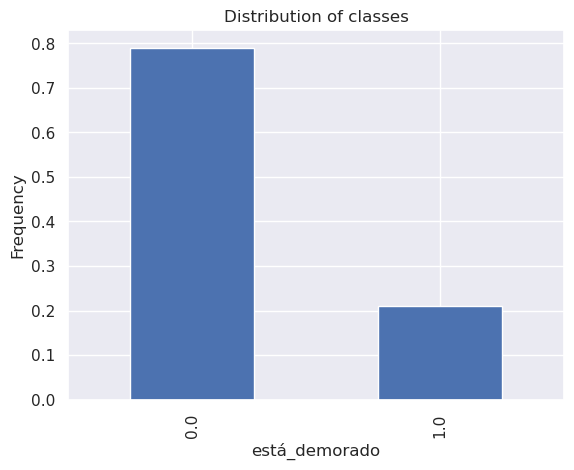

In [50]:
(data.groupby('está_demorado').size()/len(data) ).plot(kind='bar')
plt.ylabel('Frequency')
plt.title('Distribution of classes')
plt.show()

**Pregunta**: ¿Qué puede deducir del diagrama de barras sobre la relación de *demora* frente a *sin demora*?

In [ ]:
# con demora es menos abundante que sin demora

Ejecute las siguientes dos celdas y responda las preguntas.

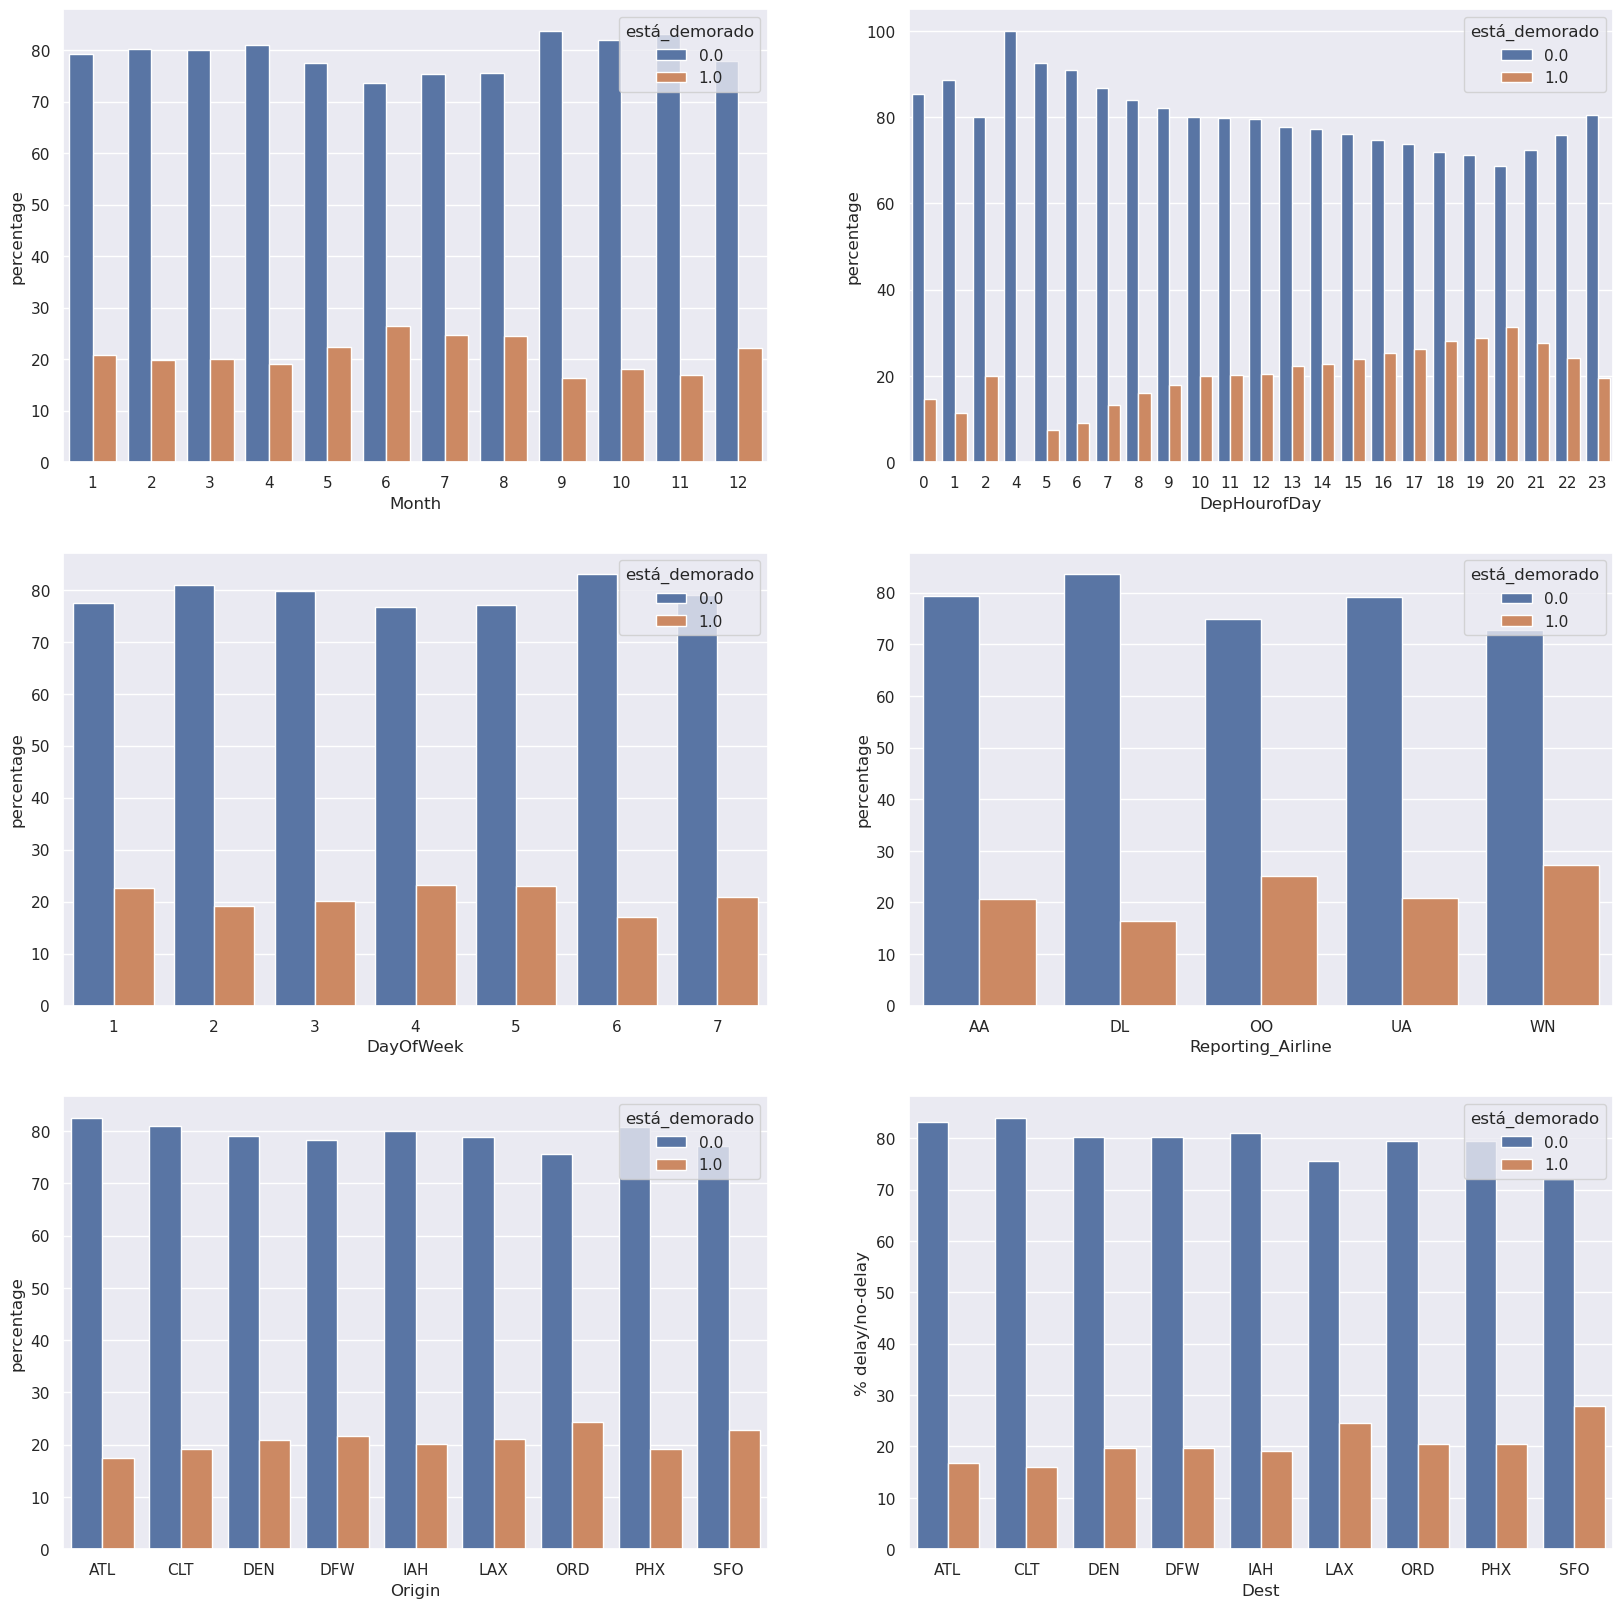

In [53]:
viz_columns = ['Month', 'DepHourofDay', 'DayOfWeek', 'Reporting_Airline', 'Origin', 'Dest']
fig, axes = plt.subplots(3, 2, figsize=(20,20), squeeze=False)
# fig.autofmt_xdate(rotation=90)

for idx, column in enumerate(viz_columns):
    ax = axes[idx//2, idx%2]
    temp = data.groupby(column)['está_demorado'].value_counts(normalize=True).rename('percentage').\
    mul(100).reset_index().sort_values(column)
    sns.barplot(x=column, y="percentage", hue="está_demorado", data=temp, ax=ax)
    plt.ylabel('% delay/no-delay')
    

plt.show()

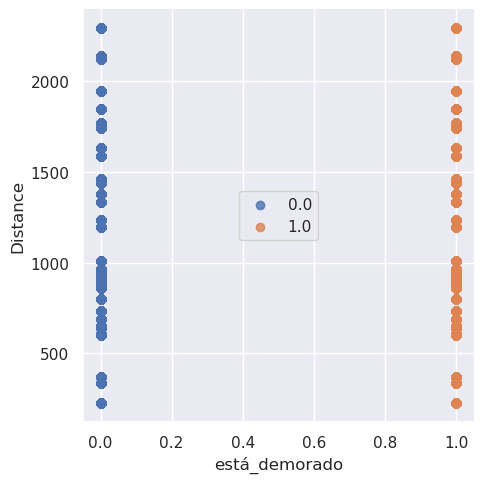

In [54]:
sns.lmplot( x="está_demorado", y="Distance", data=data, fit_reg=False, hue='está_demorado', legend=False)
plt.legend(loc='center')
plt.xlabel('está_demorado')
plt.ylabel('Distance')
plt.show()

**Preguntas**

Utilizando los datos de los gráficos anteriores, responda estas preguntas:

- ¿Qué meses tienen más demoras?
- ¿Qué hora del día tiene más demoras?
- ¿Qué día de la semana tiene más demoras?
- ¿Qué aerolínea tiene más demoras?
- ¿Qué aeropuertos de origen y destino tienen más demoras?
- ¿La distancia de vuelo es un factor en las demoras?

1. Los meses de verano (Junio, Julio y Agosto)
2. Las 20:00
3. Está entre el Lunes, Miércoles y Jueves
4. La aerolínea WN
5. ORD (Origen) SFO (Destino)
6. Sí

### Características

Mire todas las columnas y cuáles son sus tipos específicos.

In [55]:
data.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'Reporting_Airline', 'Origin', 'OriginState', 'Dest', 'DestState',
       'CRSDepTime', 'Cancelled', 'Diverted', 'Distance', 'DistanceGroup',
       'ArrDelay', 'ArrDelayMinutes', 'está_demorado', 'AirTime',
       'DepHourofDay'],
      dtype='object')

In [56]:
data.dtypes

Year                   int64
Quarter                int64
Month                  int64
DayofMonth             int64
DayOfWeek              int64
FlightDate            object
Reporting_Airline     object
Origin                object
OriginState           object
Dest                  object
DestState             object
CRSDepTime             int64
Cancelled            float64
Diverted             float64
Distance             float64
DistanceGroup          int64
ArrDelay             float64
ArrDelayMinutes      float64
está_demorado        float64
AirTime              float64
DepHourofDay           int64
dtype: object

Filtrado de columnas requeridas:
- *Fecha* es redundante, porque tiene *Año*, *Trimestre*, *Mes*, *DíaDelMes* y *DíaDeLaSemana* para describir la fecha.
- Utilice los códigos *Origen* y *Dest* en lugar de *EstadoOrig* y *EstadoDest*.
- Dado que solo está clasificando si el vuelo está retrasado o no, no necesita *TotalMinutosDemora*, *MinutosDemSalida* ni *MinutosDemLlegada*.

Trate *HoraDelDíaSalida* como una variable categórica ya que no tiene ninguna relación cuantitativa con el objetivo.
- Si necesitara hacer una codificación en caliente de esta variable, implicaría 23 columnas más.
- Otras alternativas al manejo de variables categóricas incluyen codificación hash, codificación media regularizada y depósito de valores en buckets, entre otras.
- En este caso, solo necesita dividir en buckets.

Para cambiar un tipo de columna a categoría, utilice la función `astype` ([documentación de pandas.DataFrame.astype] (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.astype.html)).

In [58]:
data_orig = data.copy()
data = data[[ 'está_demorado', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest','Distance','DepHourofDay']]
categorical_columns  = ['Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest', 'DepHourofDay']
for c in categorical_columns:
    data[c] = data[c].astype('category')

Para utilizar la codificación en caliente, utilice la función `get_dummies` en pandas para las columnas categóricas que haya seleccionado. A continuación, puede concatenar esas características generadas a su conjunto de datos original mediante el uso de la función `concat` en pandas. Para codificar variables categóricas, también puede usar *codificación ficticia* mediante una palabra clave `drop_first=True`. Para obtener más información acerca de la codificación ficticia, consulte [Variable ficticia (estadísticas)] (https://en.wikiversity.org/wiki/Dummy_variable_(statistics)).

Por ejemplo:
```
pd.get_dummies(df[['column1','columns2']], drop_first=True)
```

In [59]:
data_dummies = pd.get_dummies(data[categorical_columns], drop_first=True)

data = pd.concat([data, data_dummies], axis=1)

data.drop(categorical_columns, axis=1, inplace=True)


Compruebe la longitud del conjunto de datos y las nuevas columnas.

**Sugerencia**: Utilice las propiedades `shape` y `columns`.

In [60]:
data.shape

(1635590, 94)

In [61]:
data.columns

Index(['está_demorado', 'Distance', 'Quarter_2', 'Quarter_3', 'Quarter_4',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7',
       'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
       'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA',
       'Reporting_Airline_WN', 'Origin_CLT', 'Origin_

Ya está listo para entrenar el modelo. Antes de dividir los datos, cambie el nombre de la columna **está_demorado** a *objetivo*.

**Sugerencia**: Puede usar la función `rename` en pandas ([documentación de pandas.DataFrame.Rename] (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html)).

In [62]:
data.rename(columns = {'está_demorado':'objetivo'}, inplace=True )

## <span style="color:red"> Fin del paso 2 </span>

Guarde el archivo de muestra en su equipo local. Siga estos pasos:

1. En el explorador de archivos de la izquierda, haga clic con el botón derecho en el bloc de notas en el que está trabajando. 

2. Elija **Descargar** y guarde el archivo en forma local.  

Esta acción descarga el bloc de notas actual en la carpeta de descarga predeterminada del equipo.

# Paso 3: Entrenar y evaluar modelos

Debe incluir algunos pasos preliminares al convertir el conjunto de datos de un DataFrame a un formato que pueda utilizar un algoritmo de aprendizaje automático. Para Amazon SageMaker, debe realizar estos pasos:

1. Divida los datos en `train_data`, `validation_data` y `test_data` mediante el uso de `sklearn.model_selection.train_test_split`.  

2. Convierta el conjunto de datos a un formato de archivo adecuado que pueda utilizar el trabajo de entrenamiento de Amazon SageMaker. Puede ser un archivo CSV o un protobuf de registro. Para obtener más información, consulte [Formatos de datos comunes para entrenamiento] (https://docs.aws.amazon.com/sagemaker/latest/dg/cdf-training.html).  

3. Cargue los datos a su bucket de S3. Si no ha creado uno anteriormente, consulte [Crear un bucket] (https://docs.aws.amazon.com/AmazonS3/latest/gsg/CreatingABucket.html).  

Utilice las siguientes celdas para completar estos pasos. Inserte y elimine celdas cuando sea necesario.

#### <span style="color: blue;">Presentación del proyecto: en la presentación de su proyecto, anote las decisiones clave que tomó en esta fase.</span>

### División de entrenamiento y pruebas

In [ ]:
from sklearn.model_selection import train_test_split
def split_data(data):
    train, test_and_validate = train_test_split(data, test_size=0.2, random_state=42, stratify=data['target'])
    test, validate = train_test_split(test_and_validate, test_size=0.5, random_state=42, stratify=test_and_validate['target'])
    return train, validate, test

In [ ]:
train, validate, test = split_data(data)
print(train['target'].value_counts())
print(test['target'].value_counts())
print(validate['target'].value_counts())

**Respuesta de muestra**
```
0,0 1033570
1,0 274902
Nombre: target, dtype: int64
0,0 129076
1,0 34483
Nombre: target, dtype: int64
0,0 129612
1,0 33947
Nombre: target, dtype: int64
```

### Modelo de clasificación de referencia

In [ ]:
import sagemaker
from sagemaker.serializers import CSVSerializer
from sagemaker.amazon.amazon_estimator import RecordSet
import boto3

# Instantiate the LinearLearner estimator object with 1 ml.m4.xlarge
classifier_estimator = sagemaker.LinearLearner(role=sagemaker.get_execution_role(),
                                               instance_count=<CODE>,
                                               instance_type=<CODE>,
                                               predictor_type=<CODE>,
                                               binary_classifier_model_selection_criteria=<CODE>)

### Código de muestra
```
num_classes = len(pd.unique(train_labels))
classifier_estimator = sagemaker.LinearLearner(role=sagemaker.get_execution_role(),
                                              instance_count=1,
                                              instance_type='ml.m4.xlarge',
                                              predictor_type='binary_classifier',
                                              binary_classifier_model_selection_criteria = 'cross_entropy_loss')
                                              
```

El aprendiz lineal acepta datos de entrenamiento en tipos de contenido protobuf o CSV. También acepta solicitudes de inferencia en tipos de contenido protobuf, CSV o JavaScript Object Notation (JSON). Los datos de entrenamiento tienen características y etiquetas de verdad fundamental, pero los datos de una solicitud de inferencia solo tienen características.

En una canalización de producción, AWS recomienda convertir los datos al formato protobuf de Amazon SageMaker y almacenarlos en Amazon S3. Para ponerse en marcha rápidamente, AWS proporciona la operación `record_set` para convertir y cargar el conjunto de datos cuando es lo suficientemente pequeño como para caber en la memoria local. Acepta matrices NumPy como las que ya tiene, por lo que las usará para este paso. El objeto `RecordSet` realizará un seguimiento de la ubicación temporal de Amazon S3 de sus datos. Cree registros de entrenamiento, validación y prueba mediante la función `estimator.record_set`. A continuación, comience su trabajo de entrenamiento usando la función `estimator.fit`.

In [ ]:
### Create train, validate, and test records
train_records = classifier_estimator.record_set(train.values[:, 1:].astype(np.float32), train.values[:, 0].astype(np.float32), channel='train')
val_records = classifier_estimator.record_set(validate.values[:, 1:].astype(np.float32), validate.values[:, 0].astype(np.float32), channel='validation')
test_records = classifier_estimator.record_set(test.values[:, 1:].astype(np.float32), test.values[:, 0].astype(np.float32), channel='test')

Ahora, entrene su modelo en el conjunto de datos que acaba de cargar.

### Código de muestra
```
linear.fit([train_records,val_records,test_records])
```

In [ ]:
### Fit the classifier
# Enter your code here

## Evaluación de modelos
En esta sección, usted evaluará su modelo entrenado. 

Primero, examine las métricas para el trabajo de entrenamiento:

In [ ]:
sagemaker.analytics.TrainingJobAnalytics(classifier_estimator._current_job_name, 
                                         metric_names = ['test:objective_loss', 
                                                         'test:binary_f_beta',
                                                         'test:precision',
                                                         'test:recall']
                                        ).dataframe()

A continuación, configure algunas funciones que ayudarán a cargar los datos de prueba en Amazon S3 y realizar una predicción mediante la función de predicción por lotes. El uso de la predicción por lotes ayudará a reducir los costos, ya que las instancias solo se ejecutarán cuando se realicen predicciones en los datos de prueba suministrados.

**Nota: ** Reemplace `<LabBucketName>` por el nombre del bucket de laboratorio que se creó durante la configuración del laboratorio.

In [ ]:
import io
#bucket='<LabBucketName>'
prefix='flight-linear'
train_file='flight_train.csv'
test_file='flight_test.csv'
validate_file='flight_validate.csv'
whole_file='flight.csv'
s3_resource = boto3.Session().resource('s3')

def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False )
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

In [ ]:
def batch_linear_predict(test_data, estimator):
    batch_X = test_data.iloc[:,1:];
    batch_X_file='batch-in.csv'
    upload_s3_csv(batch_X_file, 'batch-in', batch_X)

    batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
    batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

    classifier_transformer = estimator.transformer(instance_count=1,
                                           instance_type='ml.m4.xlarge',
                                           strategy='MultiRecord',
                                           assemble_with='Line',
                                           output_path=batch_output)

    classifier_transformer.transform(data=batch_input,
                             data_type='S3Prefix',
                             content_type='text/csv',
                             split_type='Line')
    
    classifier_transformer.wait()

    s3 = boto3.client('s3')
    obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
    target_predicted_df = pd.read_json(io.BytesIO(obj['Body'].read()),orient="records",lines=True)
    return test_data.iloc[:,0], target_predicted_df.iloc[:,0]


Para ejecutar las predicciones en el conjunto de datos de prueba, ejecute la función `batch_linear_predict` (que se definió anteriormente) en el conjunto de datos de prueba.


In [ ]:
test_labels, target_predicted = batch_linear_predict(test, classifier_estimator)

Para ver una gráfica de la matriz de confusión y varias métricas de puntuación, cree un par de funciones:

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(test_labels, target_predicted):
    matrix = confusion_matrix(test_labels, target_predicted)
    df_confusion = pd.DataFrame(matrix)
    colormap = sns.color_palette("BrBG", 10)
    sns.heatmap(df_confusion, annot=True, fmt='.2f', cbar=None, cmap=colormap)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.ylabel("True Class")
    plt.xlabel("Predicted Class")
    plt.show()
    

In [ ]:
from sklearn import metrics

def plot_roc(test_labels, target_predicted):
    TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted).ravel()
    # Sensitivity, hit rate, recall, or true positive rate
    Sensitivity  = float(TP)/(TP+FN)*100
    # Specificity or true negative rate
    Specificity  = float(TN)/(TN+FP)*100
    # Precision or positive predictive value
    Precision = float(TP)/(TP+FP)*100
    # Negative predictive value
    NPV = float(TN)/(TN+FN)*100
    # Fall out or false positive rate
    FPR = float(FP)/(FP+TN)*100
    # False negative rate
    FNR = float(FN)/(TP+FN)*100
    # False discovery rate
    FDR = float(FP)/(TP+FP)*100
    # Overall accuracy
    ACC = float(TP+TN)/(TP+FP+FN+TN)*100

    print("Sensitivity or TPR: ", Sensitivity, "%") 
    print( "Specificity or TNR: ",Specificity, "%") 
    print("Precision: ",Precision, "%") 
    print("Negative Predictive Value: ",NPV, "%") 
    print( "False Positive Rate: ",FPR,"%")
    print("False Negative Rate: ",FNR, "%") 
    print("False Discovery Rate: ",FDR, "%" )
    print("Accuracy: ",ACC, "%") 

    test_labels = test.iloc[:,0];
    print("Validation AUC", metrics.roc_auc_score(test_labels, target_predicted) )

    fpr, tpr, thresholds = metrics.roc_curve(test_labels, target_predicted)
    roc_auc = metrics.auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

    # create the axis of thresholds (scores)
    ax2 = plt.gca().twinx()
    ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
    ax2.set_ylabel('Threshold',color='r')
    ax2.set_ylim([thresholds[-1],thresholds[0]])
    ax2.set_xlim([fpr[0],fpr[-1]])

    print(plt.figure())

Para trazar la matriz de confusión, llame a la función `plot_confusion_matrix` en los datos `test_labels` y `target_predicted` de su trabajo por lotes:

In [ ]:
# Enter your code here

Para imprimir estadísticas y trazar una curva de características operativas del receptor (ROC), llame a la función `plot_roc` de los datos `test_labels` y `target_predicted` del trabajo por lotes:

In [ ]:
# Enter your code here

### Preguntas clave a considerar:

1. ¿Cómo se compara el rendimiento de su modelo en el conjunto de pruebas con su rendimiento en el conjunto de entrenamiento? ¿Qué puede deducir de esta comparación? 
2. ¿Hay diferencias obvias entre los resultados de las métricas como la exactitud, la precisión y la recuperación? Si es así, ¿por qué podría estar viendo esas diferencias? 
3. Dada la situación y los objetivos de su negocio, ¿qué métrica (o métricas) es la más importante a tener en cuenta? ¿Por qué?
4. Desde el punto de vista empresarial, ¿el resultado de la métrica (o métricas) que usted considera que es el más importante es suficiente para lo que necesita? Si no es así, ¿cuáles son algunas cosas que podría cambiar en su próxima iteración? (Esto ocurrirá en la sección de diseño de características, que es la siguiente).

Utilice las celdas siguientes para responder a estas (y otras) preguntas. Inserte y elimine celdas cuando sea necesario.

#### <span style="color: blue;">Presentación del proyecto: en la presentación del proyecto, anote las respuestas a estas preguntas, y otras preguntas similares que podría contestar, en esta sección. Registre los detalles clave y las decisiones que tomó.</span>


**Pregunta**: ¿Qué puede resumir de la matriz de confusión?


In [ ]:
# Enter your answer here

## <span style="color:red"> Fin del paso 3 </span>

Guarde el archivo de muestra en su equipo local. Siga estos pasos:

1. En el explorador de archivos de la izquierda, haga clic con el botón derecho en el bloc de notas en el que está trabajando. 

2. Seleccione **Descargar** y guarde el archivo en forma local.  

Esta acción descarga el bloc de notas actual en la carpeta de descarga predeterminada del equipo.

# Iteración II

# Paso 4: Diseñar características

Ahora ha pasado por una iteración de entrenamiento y evaluación de su modelo. Dado que el primer resultado que alcanzó para su modelo probablemente no fue suficiente para resolver su problema empresarial, ¿qué podría cambiar acerca de sus datos para posiblemente mejorar el rendimiento del modelo?

### Preguntas clave a considerar:

1. ¿Cómo podría el equilibrio de sus dos clases principales (*demora* y *sin demora*) afectar el rendimiento del modelo?
2. ¿Tiene alguna característica que esté correlacionada?
3. En esta etapa, ¿podría realizar alguna técnica de reducción de características que pudiera tener un impacto positivo en el rendimiento del modelo? 
4. ¿Se le ocurre agregar más datos o conjuntos de datos?
5. Después de realizar cierto diseño de características, ¿cómo se compara el rendimiento de su modelo con la primera iteración?

Utilice las siguientes celdas para realizar técnicas específicas de diseño de características que considere que podrían mejorar el rendimiento del modelo (utilice las preguntas anteriores como guía). Inserte y elimine celdas cuando sea necesario.

#### <span style="color: blue;">Presentación del proyecto: en la presentación de su proyecto, registre sus decisiones clave y los métodos que utiliza en esta sección. Incluya también las nuevas métricas de rendimiento que obtenga después de volver a evaluar el modelo.</span>

Antes de comenzar, piense por qué la precisión y la recuperación son de alrededor del 80 %, y la exactitud es del 99 %.

Agregar más características:

1. Vacaciones
2. Clima

Debido a que se conoce la lista de vacaciones de 2014 a 2018, puede crear una variable indicadora **es_vacaciones** para marcarlos.

La hipótesis es que las demoras de los aviones podrían ser mayores durante las vacaciones en comparación con el resto de los días. Agregue una variable booleana `is_holiday` que incluya las vacaciones para los años 2014-2018.

In [ ]:
# Source: http://www.calendarpedia.com/holidays/federal-holidays-2014.html

holidays_14 = ['2014-01-01',  '2014-01-20', '2014-02-17', '2014-05-26', '2014-07-04', '2014-09-01', '2014-10-13', '2014-11-11', '2014-11-27', '2014-12-25' ] 
holidays_15 = ['2015-01-01',  '2015-01-19', '2015-02-16', '2015-05-25', '2015-06-03', '2015-07-04', '2015-09-07', '2015-10-12', '2015-11-11', '2015-11-26', '2015-12-25'] 
holidays_16 = ['2016-01-01',  '2016-01-18', '2016-02-15', '2016-05-30', '2016-07-04', '2016-09-05', '2016-10-10', '2016-11-11', '2016-11-24', '2016-12-25', '2016-12-26']
holidays_17 = ['2017-01-02', '2017-01-16', '2017-02-20', '2017-05-29' , '2017-07-04', '2017-09-04' ,'2017-10-09', '2017-11-10', '2017-11-23', '2017-12-25']
holidays_18 = ['2018-01-01', '2018-01-15', '2018-02-19', '2018-05-28' , '2018-07-04', '2018-09-03' ,'2018-10-08', '2018-11-12','2018-11-22', '2018-12-25']
holidays = holidays_14+ holidays_15+ holidays_16 + holidays_17+ holidays_18

### Add indicator variable for holidays
data_orig['is_holiday'] = # Enter your code here 

Los datos meteorológicos se obtuvieron de https://www.ncei.noaa.gov/access/services/data/v1?dataset=daily-summaries&amp;stations=USW00023174,USW00012960,USW00003017,USW00094846,USW00013874,USW00023234,USW00003927,USW00023183,USW00013881&amp;dataTypes=AWND,PRCP,SNOW,SNWD,TAVG,TMIN,TMAX&amp;startDate=2014-01-01&amp;endDate =2018-12-31.
<br>

Este conjunto de datos contiene información sobre la velocidad del viento, las precipitaciones, la nieve y la temperatura de las ciudades según sus códigos de aeropuerto.

**Pregunta**: ¿Podría el mal tiempo debido a lluvia, fuertes vientos o nieve provocar demoras en los aviones? Ahora lo comprobará.

In [ ]:
!aws s3 cp s3://aws-tc-largeobjects/CUR-TF-200-ACMLFO-1/flight_delay_project/data2/daily-summaries.csv /home/ec2-user/SageMaker/project/data/
#!wget 'https://www.ncei.noaa.gov/access/services/data/v1?dataset=daily-summaries&stations=USW00023174,USW00012960,USW00003017,USW00094846,USW00013874,USW00023234,USW00003927,USW00023183,USW00013881&dataTypes=AWND,PRCP,SNOW,SNWD,TAVG,TMIN,TMAX&startDate=2014-01-01&endDate=2018-12-31' -O /home/ec2-user/SageMaker/project/data/daily-summaries.csv

Importe los datos meteorológicos que se prepararon para los códigos de aeropuerto en el conjunto de datos. Utilice las siguientes estaciones y aeropuertos para el análisis. Cree una nueva columna llamada *aeropuerto* que asigne la estación meteorológica al nombre del aeropuerto.

In [ ]:
weather = pd.read_csv('/home/ec2-user/SageMaker/project/data/daily-summaries.csv')
station = ['USW00023174','USW00012960','USW00003017','USW00094846','USW00013874','USW00023234','USW00003927','USW00023183','USW00013881'] 
airports = ['LAX', 'IAH', 'DEN', 'ORD', 'ATL', 'SFO', 'DFW', 'PHX', 'CLT']

### Map weather stations to airport code
station_map = {s:a for s,a in zip(station, airports)}
weather['airport'] = weather['STATION'].map(station_map)

En la columna **FECHA**, cree otra columna llamada *MES*.

In [ ]:
weather['MONTH'] = weather['DATE'].apply(lambda x: x.split('-')[1])
weather.head()

### Muestra de archivo de salida
```
  STATION     DATE      AWND PRCP SNOW SNWD TAVG TMAX  TMIN airport MONTH
0 USW00023174 2014-01-01 16   0   NaN  NaN 131.0 178.0 78.0  LAX    01
1 USW00023174 2014-01-02 22   0   NaN  NaN 159.0 256.0 100.0 LAX    01
2 USW00023174 2014-01-03 17   0   NaN  NaN 140.0 178.0 83.0  LAX    01
3 USW00023174 2014-01-04 18   0   NaN  NaN 136.0 183.0 100.0 LAX    01
4 USW00023174 2014-01-05 18   0   NaN  NaN 151.0 244.0 83.0  LAX    01
```

Analice y gestione las columnas **NIEVE** y **NEVD** en función de los valores que faltan utilizando `fillna()`. Para comprobar los valores que faltan para todas las columnas, utilice la función `isna()`.

In [ ]:
weather.SNOW.fillna(0, inplace=True)
weather.SNWD.fillna(0, inplace=True)
weather.isna().sum()

**Pregunta**: imprima el índice de las filas que tienen valores faltantes para *TPROM*, *TMÁX*, *TMÍN*.

**Sugerencia**: Para encontrar las filas que faltan, utilice la función `isna()`. A continuación, para obtener el índice, utilice la lista de la variable *índ*.

In [ ]:
idx = np.array([i for i in range(len(weather))])
TAVG_idx = idx[weather.TAVG.isna()] 
TMAX_idx = # Enter your code here 
TMIN_idx = # Enter your code here 
TAVG_idx

### Muestra de archivo de salida

```
array([ 3956,  3957,  3958,  3959,  3960,  3961,  3962,  3963,  3964,
        3965,  3966,  3967,  3968,  3969,  3970,  3971,  3972,  3973,
        3974,  3975,  3976,  3977,  3978,  3979,  3980,  3981,  3982,
        3983,  3984,  3985,  4017,  4018,  4019,  4020,  4021,  4022,
        4023,  4024,  4025,  4026,  4027,  4028,  4029,  4030,  4031,
        4032,  4033,  4034,  4035,  4036,  4037,  4038,  4039,  4040,
        4041,  4042,  4043,  4044,  4045,  4046,  4047, 13420])
```

Puede reemplazar los valores faltantes *TPROM*, *TMÁX* y *TMÍN* por el valor promedio de una estación o aeropuerto en particular. Debido a que faltan filas consecutivas de *TPROM_índ*, no sería posible reemplazarlas por un valor anterior. En su lugar, reemplácelos con la media. Utilice la función `groupby` para agregar las variables con un valor medio.

**Sugerencia: ** Agrupe por `MONTH` y `STATION`.

In [ ]:
weather_impute = weather.groupby([<CODE>]).agg({'TAVG':'mean','TMAX':'mean', 'TMIN':'mean' }).reset_index()# Enter your code here
weather_impute.head(2)

Combine los datos medios con los datos meteorológicos.

In [ ]:

weather = pd.merge(weather, weather_impute,  how='left', left_on=['MONTH','STATION'], right_on = ['MONTH','STATION'])\
.rename(columns = {'TAVG_y':'TAVG_AVG',
                   'TMAX_y':'TMAX_AVG', 
                   'TMIN_y':'TMIN_AVG',
                   'TAVG_x':'TAVG',
                   'TMAX_x':'TMAX', 
                   'TMIN_x':'TMIN'})

Vuelva a comprobar si faltan valores.

In [ ]:
weather.TAVG[TAVG_idx] = weather.TAVG_AVG[TAVG_idx]
weather.TMAX[TMAX_idx] = weather.TMAX_AVG[TMAX_idx]
weather.TMIN[TMIN_idx] = weather.TMIN_AVG[TMIN_idx]
weather.isna().sum()

Elimine `STATION,MONTH,TAVG_AVG,TMAX_AVG,TMIN_AVG,TMAX,TMIN,SNWD` del conjunto de datos.

In [ ]:
weather.drop(columns=['STATION','MONTH','TAVG_AVG', 'TMAX_AVG', 'TMIN_AVG', 'TMAX' ,'TMIN', 'SNWD'],inplace=True)

Agregue las condiciones meteorológicas de origen y destino al conjunto de datos.

In [ ]:
### Add origin weather conditions
data_orig = pd.merge(data_orig, weather,  how='left', left_on=['FlightDate','Origin'], right_on = ['DATE','airport'])\
.rename(columns = {'AWND':'AWND_O','PRCP':'PRCP_O', 'TAVG':'TAVG_O', 'SNOW': 'SNOW_O'})\
.drop(columns=['DATE','airport'])

### Add destination weather conditions
data_orig = pd.merge(data_orig, weather,  how='left', left_on=['FlightDate','Dest'], right_on = ['DATE','airport'])\
.rename(columns = {'AWND':'AWND_D','PRCP':'PRCP_D', 'TAVG':'TAVG_D', 'SNOW': 'SNOW_D'})\
.drop(columns=['DATE','airport'])

**Nota**: Siempre es una buena práctica comprobar si hay valores nulos o no disponibles después de las uniones.

In [ ]:
sum(data.isna().any())

In [ ]:
data_orig.columns

Convierta los datos categóricos en datos numéricos mediante la codificación en caliente.

In [ ]:
data = data_orig.copy()
data = data[['is_delay', 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest','Distance','DepHourofDay','is_holiday', 'AWND_O', 'PRCP_O',
       'TAVG_O', 'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D']]


categorical_columns  = ['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest', 'is_holiday']
for c in categorical_columns:
    data[c] = data[c].astype('category')

In [ ]:
data_dummies = pd.get_dummies(data[['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'Reporting_Airline', 'Origin', 'Dest', 'is_holiday']], drop_first=True)
data = pd.concat([data, data_dummies], axis = 1)
data.drop(categorical_columns,axis=1, inplace=True)

Compruebe las nuevas columnas.

In [ ]:
data.shape

In [ ]:
data.columns

### Muestra de archivo de salida

```
Index(['Distance', 'DepHourofDay', 'is_delay', 'AWND_O', 'PRCP_O', 'TAVG_O',
       'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D', 'Year_2015',
       'Year_2016', 'Year_2017', 'Year_2018', 'Quarter_2', 'Quarter_3',
       'Quarter_4', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
       'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
       'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA',
       'Reporting_Airline_WN', 'Origin_CLT', 'Origin_DEN', 'Origin_DFW',
       'Origin_IAH', 'Origin_LAX', 'Origin_ORD', 'Origin_PHX', 'Origin_SFO',
       'Dest_CLT', 'Dest_DEN', 'Dest_DFW', 'Dest_IAH', 'Dest_LAX', 'Dest_ORD',
       'Dest_PHX', 'Dest_SFO', 'is_holiday_1'],
      dtype='object')
```

Cambie el nombre de la columna **está_demorado** a *objetivo* nuevamente. Use el mismo código que usó anteriormente.

In [ ]:
data.rename(columns = {<CODE>:<CODE>}, inplace=True )# Enter your code here

Vuelva a crear los conjuntos de entrenamiento.

**Sugerencia: ** Utilice la función `split_data` que definió (y usó) anteriormente.

In [ ]:
# Enter your code here

### Nuevo clasificador de referencia

Ahora, vea si estas nuevas características agregan potencia predictiva al modelo.

In [ ]:
# Instantiate the LinearLearner estimator object
classifier_estimator2 = # Enter your code here

### Código de muestra

```
num_classes = len(pd.unique(train_labels)) 
classifier_estimator2 = sagemaker.LinearLearner(role=sagemaker.get_execution_role(),
                                               instance_count=1,
                                               instance_type='ml.m4.xlarge',
                                               predictor_type='binary_classifier',
                                               binary_classifier_model_selection_criteria = 'cross_entropy_loss')
```

In [ ]:
train_records = classifier_estimator2.record_set(train.values[:, 1:].astype(np.float32), train.values[:, 0].astype(np.float32), channel='train')
val_records = classifier_estimator2.record_set(validate.values[:, 1:].astype(np.float32), validate.values[:, 0].astype(np.float32), channel='validation')
test_records = classifier_estimator2.record_set(test.values[:, 1:].astype(np.float32), test.values[:, 0].astype(np.float32), channel='test')

Entrene su modelo utilizando los tres conjuntos de datos que acaba de crear.

In [ ]:
# Enter your code here

Realice una predicción por lotes utilizando el modelo recién entrenado.

In [ ]:
# Enter your code here

Trace una matriz de confusión.

In [ ]:
# Enter your code here

Trace la curva ROC.

In [ ]:
# Enter your code here

El modelo lineal muestra solo una leve mejora en el rendimiento. Pruebe un modelo de ensamble basado en árboles, que se denomina *XGBoost*, con Amazon SageMaker.

### Pruebe el modelo XGBoost

Realice estos pasos:  

1. Utilice las variables del conjunto de entrenamiento y guárdelas como archivos CSV: train.csv, validation.csv y test.csv.
2. Almacene el nombre del bucket en la variable. El nombre del bucket de Amazon S3 se proporciona a la izquierda de las instrucciones del laboratorio.  
a. `bucket = <LabBucketName>`  
b. `prefix = 'flight-xgb'`  
3. Utilice AWS SDK for Python (Boto3) para cargar el modelo en el bucket.    

In [ ]:
bucket='c141604a3635658l8597922t1w56442246292-flightbucket-ilu7gh15umzn'
prefix='flight-xgb'
train_file='flight_train.csv'
test_file='flight_test.csv'
validate_file='flight_validate.csv'
whole_file='flight.csv'
s3_resource = boto3.Session().resource('s3')

def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False )
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

upload_s3_csv(train_file, 'train', train)
upload_s3_csv(test_file, 'test', test)
upload_s3_csv(validate_file, 'validate', validate)

Utilice la función `sagemaker.inputs.TrainingInput` para crear un `record_set` para los conjuntos de datos de entrenamiento y validación.

In [ ]:
train_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/train/".format(bucket,prefix,train_file),
    content_type='text/csv')

validate_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/validate/".format(bucket,prefix,validate_file),
    content_type='text/csv')

data_channels = {'train': train_channel, 'validation': validate_channel}

In [ ]:
from sagemaker.image_uris import retrieve
container = retrieve('xgboost',boto3.Session().region_name,'1.0-1')

In [ ]:
sess = sagemaker.Session()
s3_output_location="s3://{}/{}/output/".format(bucket,prefix)

xgb = sagemaker.estimator.Estimator(container,
                                    role = sagemaker.get_execution_role(), 
                                    instance_count=1, 
                                    instance_type=instance_type,
                                    output_path=s3_output_location,
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        eval_metric = "auc", 
                        num_round=100)

xgb.fit(inputs=data_channels)

Utilice el transformador por lotes para su nuevo modelo y evalúe el modelo en el conjunto de datos de prueba.

In [ ]:
batch_X = test.iloc[:,1:];
batch_X_file='batch-in.csv'
upload_s3_csv(batch_X_file, 'batch-in', batch_X)

In [ ]:
batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

xgb_transformer = xgb.transformer(instance_count=1,
                                       instance_type=instance_type,
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)

xgb_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
xgb_transformer.wait()

Obtenga las etiquetas de destino y de prueba previstas.

In [ ]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),',',names=['target'])
test_labels = test.iloc[:,0]

Calcule los valores previstos según el umbral definido.

**Nota:** El objetivo previsto será una puntuación, que debe convertirse a una clase binaria.

In [ ]:
print(target_predicted.head())

def binary_convert(x):
    threshold = 0.55
    if x > threshold:
        return 1
    else:
        return 0

target_predicted['target'] = target_predicted['target'].apply(binary_convert)

test_labels = test.iloc[:,0]

print(target_predicted.head())

Trace una matriz de confusión para su `target_predicted` y `test_labels`.

In [ ]:
# Enter your code here

Trace el diagrama ROC:

In [ ]:
# Enter your code here

### Pruebe diferentes umbrales

**Pregunta**: En función de lo bien que el modelo manejó el conjunto de pruebas, ¿qué puede concluir?

In [ ]:
#Enter your answer here

### Optimización de hiperparámetros (HPO, Hyperparameter optimization)

In [ ]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

### You can spin up multiple instances to do hyperparameter optimization in parallel

xgb = sagemaker.estimator.Estimator(container,
                                    role=sagemaker.get_execution_role(), 
                                    instance_count= 1, # make sure you have a limit set for these instances
                                    instance_type=instance_type, 
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)

xgb.set_hyperparameters(eval_metric='auc',
                        objective='binary:logistic',
                        num_round=100,
                        rate_drop=0.3,
                        tweedie_variance_power=1.4)

hyperparameter_ranges = {'alpha': ContinuousParameter(0, 1000, scaling_type='Linear'),
                         'eta': ContinuousParameter(0.1, 0.5, scaling_type='Linear'),
                         'min_child_weight': ContinuousParameter(3, 10, scaling_type='Linear'),
                         'subsample': ContinuousParameter(0.5, 1),
                         'num_round': IntegerParameter(10,150)}

objective_metric_name = 'validation:auc'

tuner = HyperparameterTuner(xgb,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=10, # Set this to 10 or above depending upon budget and available time.
                            max_parallel_jobs=1)

In [ ]:
tuner.fit(inputs=data_channels)
tuner.wait()

<i class="fas fa-exclamation-triangle" style="color:red"></i> Espere hasta que finalice el trabajo de entrenamiento. Podría tardar entre 25 y 30 minutos.

**Para supervisar los trabajos de optimización de hiperparámetros:**  

1. En la consola de administración de AWS, en el menú **Services (Servicios)**, elija **Amazon SageMaker**.  
2. Elija **Training (Entrenamiento) > Hyperparameter tuning jobs (Trabajos de ajuste de hiperparámetros)**.
3. Puede comprobar el estado de cada trabajo de ajuste de hiperparámetros, su valor de métrica objetivo y sus registros.  

Compruebe que el trabajo se ha completado correctamente.

In [ ]:
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

El trabajo de ajuste de hiperparámetros tendrá un modelo que funcionó mejor. Puede obtener la información sobre ese modelo desde el trabajo de ajuste.

In [ ]:
sage_client = boto3.Session().client('sagemaker')
tuning_job_name = tuner.latest_tuning_job.job_name
print(f'tuning job name:{tuning_job_name}')
tuning_job_result = sage_client.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)
best_training_job = tuning_job_result['BestTrainingJob']
best_training_job_name = best_training_job['TrainingJobName']
print(f"best training job: {best_training_job_name}")

best_estimator = tuner.best_estimator()

tuner_df = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name).dataframe()
tuner_df.head()

Utilice el estimador `best_estimator` y entrénelo utilizando los datos. 

**Sugerencia: ** Consulte la función de ajuste del estimador XGBoost anterior.

In [ ]:
# Enter your code here'

Utilice el transformador por lotes para su nuevo modelo y evalúe el modelo en el conjunto de datos de prueba.

In [ ]:
batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

xgb_transformer = best_estimator.transformer(instance_count=1,
                                       instance_type=instance_type,
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)

xgb_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
xgb_transformer.wait()

In [ ]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),',',names=['target'])
test_labels = test.iloc[:,0]

Obtenga las etiquetas de destino y de prueba previstas.

In [ ]:
print(target_predicted.head())

def binary_convert(x):
    threshold = 0.55
    if x > threshold:
        return 1
    else:
        return 0

target_predicted['target'] = target_predicted['target'].apply(binary_convert)

test_labels = test.iloc[:,0]

print(target_predicted.head())

Trace una matriz de confusión para su `target_predicted` y `test_labels`.

In [ ]:
# Enter your code here

Trace el diagrama ROC:

In [ ]:
# Enter your code here

**Pregunta**: Pruebe diferentes hiperparámetros y rangos de hiperparámetros. ¿Estos cambios mejoran el modelo?

## Conclusión

Ahora ha iterado a través del entrenamiento y la evaluación de su modelo al menos un par de veces. Es hora de concluir este proyecto y reflexionar sobre:

- Lo que aprendió 
- Qué tipos de pasos puede tomar para avanzar (suponiendo que tiene más tiempo)

Utilice la siguiente celda para responder algunas de estas preguntas y otras preguntas relevantes:

1. ¿El rendimiento de su modelo cumple con su objetivo de negocio? Si no lo hace, ¿cuáles son algunas cosas que le gustaría hacer de manera diferente si tuviera más tiempo para realizar ajustes?
2. ¿Cuánto mejoró su modelo a medida que realizó cambios en el conjunto de datos, las características y los hiperparámetros? ¿Qué tipos de técnicas empleó a lo largo de este proyecto y cuáles produjeron las mayores mejoras en su modelo?
3. ¿Cuáles fueron algunos de los mayores desafíos que se encontraron a lo largo de este proyecto?
4. ¿Tiene alguna pregunta sin respuesta sobre aspectos de la canalización que no tenga sentido para usted?
5. ¿Cuáles fueron las tres cosas más importantes que aprendió sobre el aprendizaje automático mientras trabajaba en este proyecto?

#### <span style="color: blue;">Presentación del proyecto: Asegúrese de resumir las respuestas a estas preguntas en la presentación del proyecto. Combine todas sus notas para la presentación de su proyecto y prepárese para presentar sus conclusiones a la clase.</span>

In [ ]:
# Write your answers here